In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Without noise

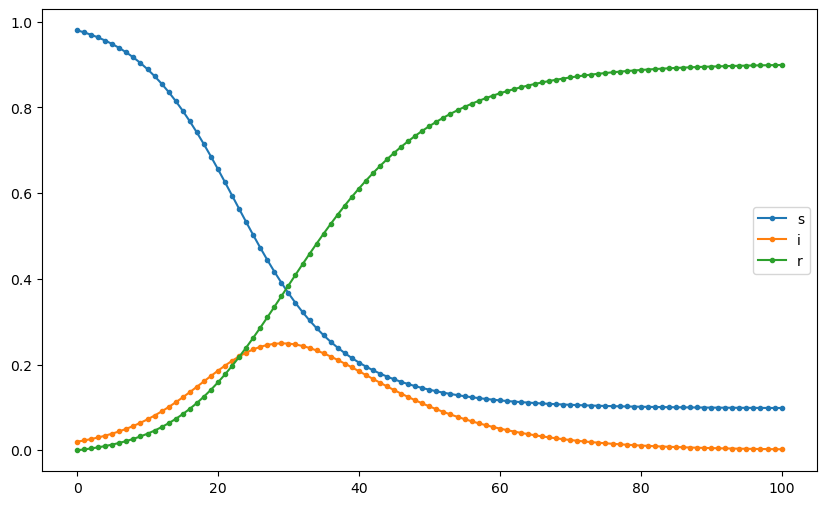

In [2]:
beta=0.25
gamma=0.1

N=100

t = np.zeros(N+1)
sir = np.zeros(3*(N+1)).reshape(3, -1)

sir[0,0]=0.98
sir[1,0]=0.02
sir[2,0]=0

for i in range(N):
    sir[0,i+1]=sir[0,i]-beta*sir[0,i]*sir[1,i]
    sir[1,i+1]=sir[1,i]+(beta*sir[0,i]*sir[1,i] - gamma*sir[1,i])
    sir[2,i+1]=sir[2,i]+gamma*sir[1,i]
    t[i+1]=i+1
    
plt.figure(figsize=(10, 6))
plt.plot(sir[0, :], 'o-', label = "s", markersize=3)
plt.plot(sir[1, :], 'o-', label = "i", markersize=3)
plt.plot(sir[2, :], 'o-', label = "r", markersize=3)

plt.legend()

### (1) first-order backward differences

In [3]:
n = 1
s = sir[0]
i = sir[1]
r = sir[2]

a1=sum([i[j-1]*i[j]*s[j]-i[j]*s[j-1]*s[j]-(i[j]**2)*s[j]+i[j]*(s[j]**2) for j in range(1,N-1)])
a2=sum([(i[j]**2) for j in range(1,N-1)])
a3=sum([i[j-1]*i[j]-(i[j]**2)-i[j]*r[j-1]+i[j]*r[j] for j in range(1,N-1)])
a4=sum([(i[j]**2)*s[j] for j in range(1,N-1)])
a5=sum([(i[j]**2)*(s[j]**2) for j in range(1,N-1)])
a6=sum([(i[j]**2) for j in range(1,N-1)])

beta = ((-8/n)*a1*a2+(4/n)*a3*a4)/((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))
gamma = ((8/(n**2))*a5*a3-(4/(n**2))*a4*a1)/((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))

print('beta: ',beta)
print("gamma: ", gamma)

beta:  0.2512537626651678
gamma:  0.0989404422650005


### (2) first-order forward differences

In [4]:
n = 1
s = sir[0]
i = sir[1]
r = sir[2]

a1=sum([i[j]*s[j]*(s[j+1]-s[j]-i[j+1]+i[j]) for j in range(0,N-1)])
a2=sum([(i[j]**2) for j in range(0,N-1)])
a3=sum([i[j]*(i[j+1]*-i[j]-r[j+1]+r[j]) for j in range(0,N-1)])
a4=sum([(i[j]**2)*s[j] for j in range(0,N-1)])
a5=sum([(i[j]**2)*(s[j]**2) for j in range(0,N-1)])
a6=sum([(i[j]**2) for j in range(0,N-1)])

beta = ((-8/n)*a1*a2-(4/n)*a3*a4) / ((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))
gamma = ((-8/(n**2))*a5*a3-(4/(n**2))*a4*a1) / ((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))

print('beta: ',beta)
print("gamma: ", gamma)

beta:  0.37429434891598573
gamma:  0.22289824722596424


### (3) second-order centered differences

In [5]:
n = 1
s = sir[0]
i = sir[1]
r = sir[2]

a1 = sum([i[j-1]*i[j]*s[j]-i[j]*s[j-1]*s[j]-i[j]*i[j+1]*s[j]+i[j]*s[j+1]*s[j] for j in range(1, N-1)])
a2 = sum([i[j]**2 for j in range(1, N-1)])
a3 = sum([i[j]*r[j+1]-i[j]*r[j-1] for j in range(1, N-1)])-i[0]*i[1]+i[N-1]*i[N]
a4 = sum([i[j]**2*s[j] for j in range(1, N-1)])
a5 = sum([(i[j]**2)*(s[j]**2) for j in range(1, N-1)])

beta = (-(4/n)*a1*a2+(2/n)*a3*a4)/((16/(n**2))*a5*a2-(4/(n**2))*(a4**2))
gamma = ((4/(n**2))*a5*a3-(2/(n**2)*a4*a1))/((16/(n**2))*a5*a2-(4/(n**2))*(a4**2))

print(beta)
print(gamma)

0.2504363061524995
0.09928190933548335


### PINN

In [6]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim  
import torch.nn.functional as F
import numpy as np
import time

In [7]:
y_sol_tensor = Tensor(sir.T)
t_sol_tensor = Tensor(t.reshape(-1, 1))

In [8]:
class DNN(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        """
        relu, leaky_relu, softplus, tanh
        """
        """
        softplus: 하이브리드에서 잘 작동한다.
        """
        
        self.act_fn = F.softplus
        
        self.l1 = nn.Linear(1, 16)
        self.l2 = nn.Linear(16, 32)
        self.l3 = nn.Linear(32, 64)
        self.l4 = nn.Linear(64, 32)
        self.l5 = nn.Linear(32, 16)
        self.l6 = nn.Linear(16, 3)
    
    def forward(self, x):
        x = self.act_fn(self.l1(x))
        x = self.act_fn(self.l2(x))
        x = self.act_fn(self.l3(x))
        x = self.act_fn(self.l4(x))
        x = self.act_fn(self.l5(x))
        x = self.l6(x)
        return x

In [9]:
class FCN():
    
    def __init__(self, beta, gamma, inverse=True):
        
        self.inverse = inverse
        
        self.iter = 0
        
        self.beta = beta
        self.gamma = gamma
        
        self.beta_list = [self.beta]
        self.gamma_list = [self.gamma]
        
        self.loss_function = nn.MSELoss(reduction ='mean')
        
        'Call our DNN'
        self.dnn = DNN()
        
        if self.inverse:
            'Initialize our new parameters i.e. 𝜆 (Inverse problem)' 
            self.beta = torch.tensor([beta], requires_grad=True).float()
            self.gamma = torch.tensor([gamma], requires_grad=True).float() 
            'Register lambda to optimize'
            self.beta = nn.Parameter(self.beta)
            self.gamma = nn.Parameter(self.gamma)
            'Register our new parameter'
            self.dnn.register_parameter('beta', self.beta)  
            self.dnn.register_parameter('gamma', self.gamma)
        else:
            pass
    
    def loss_data(self, t_sol_tensor, y_sol_tensor):
        
        output = self.dnn(t_sol_tensor)
        
        loss_1 = self.loss_function(output, y_sol_tensor)
        
        return loss_1
    
    def loss_slope(self, t_sol_tensor, y_sol_tensor):
        
        g = t_sol_tensor.clone()
        g.requires_grad = True
        
        u = self.dnn(g)
        
        if self.inverse:
            S = y_sol_tensor[:, 0]
            I = y_sol_tensor[:, 1]
            R = y_sol_tensor[:, 2]
        else:
            S = u[:, 0].reshape(-1, 1)
            I = u[:, 1].reshape(-1, 1)
            R = u[:, 2].reshape(-1, 1)
        
        
        S_m = u[:, 0].reshape(-1, 1)
        I_m = u[:, 1].reshape(-1, 1)
        R_m = u[:, 2].reshape(-1, 1)

        S_m_t = autograd.grad(S_m, g, torch.ones((t_sol_tensor.shape[0],1)), retain_graph=True, create_graph=True)[0]
        I_m_t = autograd.grad(I_m, g, torch.ones((t_sol_tensor.shape[0],1)), retain_graph=True, create_graph=True)[0]
        R_m_t = autograd.grad(R_m, g, torch.ones((t_sol_tensor.shape[0],1)), retain_graph=True, create_graph=True)[0]
        
        S_t = (-self.beta*S*I)
        I_t = self.beta*S*I - self.gamma*I
        R_t = self.gamma*I
        
        loss_S = self.loss_function(S_m_t, S_t.reshape(-1, 1))
        loss_I = self.loss_function(I_m_t, I_t.reshape(-1, 1))
        loss_R = self.loss_function(R_m_t, R_t.reshape(-1, 1))
        
        SIR_m_t = S_m_t + I_m_t + R_m_t
        
        SIR_0 = torch.zeros(SIR_m_t.shape[0], SIR_m_t.shape[1])

        SIR_loss = self.loss_function(SIR_m_t, SIR_0)

        
        loss_2 = loss_S + loss_I + loss_R + SIR_loss
        
        return loss_2
    
    def loss_initial(self, t_sol_tensor, y_sol_tensor):
        
        S_0 = y_sol_tensor[0, 0]
        I_0 = y_sol_tensor[0, 1]
        R_0 = y_sol_tensor[0, 2]
        
        output = self.dnn(t_sol_tensor)
        
        S_m_0 = output[0, 0]
        I_m_0 = output[0, 1]
        R_m_0 = output[0, 2]
    
        loss_S_0 = self.loss_function(S_0, S_m_0)
        loss_I_0 = self.loss_function(I_0, I_m_0)
        loss_R_0 = self.loss_function(R_0, R_m_0)
        
        loss_3 = loss_S_0+loss_I_0+loss_R_0
        
        return loss_3
        
    def total_loss(self, t_sol_tensor, y_sol_tensor):
        
        if self.inverse:
            loss_1 = self.loss_data(t_sol_tensor, y_sol_tensor)
        else:
            loss_1 = 0
            
        loss_2 = self.loss_slope(t_sol_tensor, y_sol_tensor)
        
        loss_3 = self.loss_initial(t_sol_tensor, y_sol_tensor)
        
        loss_4 = loss_2 + loss_3 + loss_1 
        
        return loss_4
        
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.total_loss(t_sol_tensor, y_sol_tensor)
        
        loss.backward()
        
        self.iter += 1
        
        #if self.beta[0]<0.22:
        #    print("!!!")
        
        self.beta_list.append(self.beta[0].detach().numpy())
        self.gamma_list.append(self.gamma[0].detach().numpy())
        
        if self.iter%500==0 and self.inverse:
            
            error, output = PINN.test()
            print(f"beta, gamma: {self.beta[0]}, {self.gamma[0]}, error: {error}")
            
    def test(self):
        
        output = self.dnn(t_sol_tensor)
        
        error = torch.linalg.norm((y_sol_tensor-output))
                                  
        output = output.detach().numpy()
        
        return error, output

In [10]:
torch.manual_seed(1234)

beta_hat = 0.5
gamma_hat = 0.5

PINN = FCN(beta_hat, gamma_hat, inverse=True)

'Neural Network Summary'
print(PINN)

params = list(PINN.dnn.parameters())

optimizer  = torch.optim.Adam(params, lr = 0.03)

N_epochs = 1000
 
for i in range(N_epochs+1):
    optimizer.step(PINN.closure)

beta, gamma: 0.2503105103969574, 0.09920346736907959, error: 0.06643948704004288
beta, gamma: 0.2511947453022003, 0.09994540363550186, error: 0.05870389938354492


In [11]:
S = PINN.test()[1][:, 0]
I = PINN.test()[1][:, 1]
R = PINN.test()[1][:, 2]

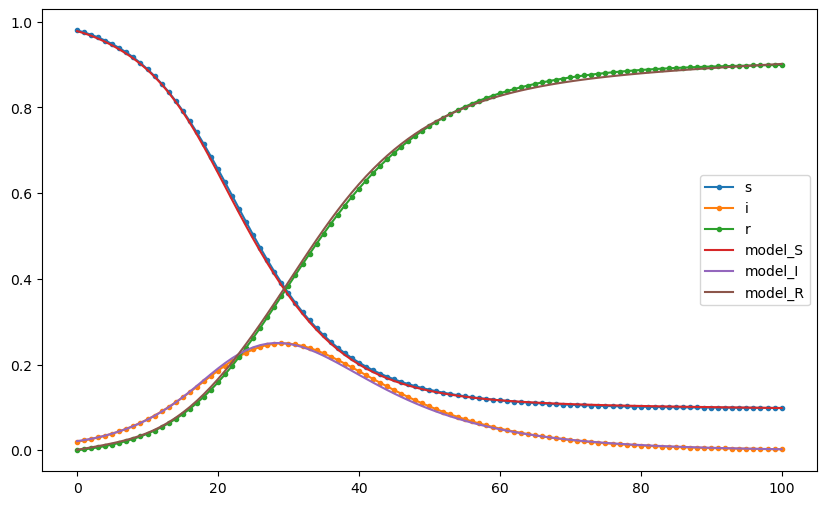

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(t, sir[0, :], 'o-', label = "s", markersize=3)
plt.plot(t, sir[1, :], 'o-', label = "i", markersize=3)
plt.plot(t, sir[2, :], 'o-', label = "r", markersize=3)

plt.plot(t, S, label="model_S")
plt.plot(t, I, label="model_I")
plt.plot(t, R, label="model_R")

plt.legend()

# With noise

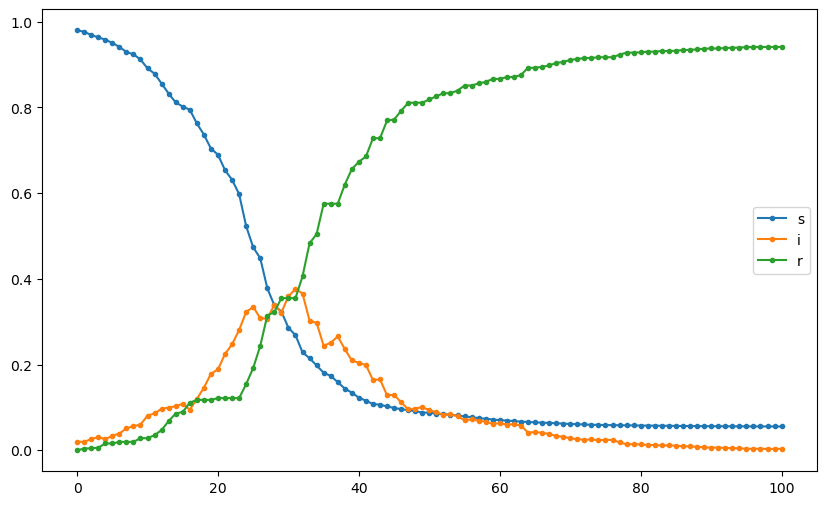

In [13]:
np.random.seed(4321)

beta=0.25
gamma=0.1

N=100

t = np.zeros(N+1)
sir = np.zeros(3*(N+1)).reshape(3, -1)

sir[0,0]=0.98
sir[1,0]=0.02
sir[2,0]=0

for i in range(N):
    
    beta_noise = max(0, beta+np.random.randn(1)*0.1)
    gamma_noise = max(0, gamma+np.random.randn(1)*0.1)
    
    sir[0,i+1]=sir[0,i]-beta_noise*sir[0,i]*sir[1,i]
    sir[1,i+1]=sir[1,i]+(beta_noise*sir[0,i]*sir[1,i] - gamma_noise*sir[1,i])
    sir[2,i+1]=sir[2,i]+gamma_noise*sir[1,i]
    t[i+1]=i+1
    
plt.figure(figsize=(10, 6))
plt.plot(sir[0, :], 'o-', label = "s", markersize=3)
plt.plot(sir[1, :], 'o-', label = "i", markersize=3)
plt.plot(sir[2, :], 'o-', label = "r", markersize=3)

plt.legend()

### (1) first-order backward differences

In [14]:
n = 1
s = sir[0]
i = sir[1]
r = sir[2]

a1=sum([i[j-1]*i[j]*s[j]-i[j]*s[j-1]*s[j]-(i[j]**2)*s[j]+i[j]*(s[j]**2) for j in range(1,N-1)])
a2=sum([(i[j]**2) for j in range(1,N-1)])
a3=sum([i[j-1]*i[j]-(i[j]**2)-i[j]*r[j-1]+i[j]*r[j] for j in range(1,N-1)])
a4=sum([(i[j]**2)*s[j] for j in range(1,N-1)])
a5=sum([(i[j]**2)*(s[j]**2) for j in range(1,N-1)])
a6=sum([(i[j]**2) for j in range(1,N-1)])

beta = ((-8/n)*a1*a2+(4/n)*a3*a4)/((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))
gamma = ((8/(n**2))*a5*a3-(4/(n**2))*a4*a1)/((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))

print('beta: ',beta)
print("gamma: ", gamma)

beta:  0.2762086646252431
gamma:  0.08942147571249595


### (2) first-order forward differences

In [15]:
n = 1
s = sir[0]
i = sir[1]
r = sir[2]

a1=sum([i[j]*s[j]*(s[j+1]-s[j]-i[j+1]+i[j]) for j in range(0,N-1)])
a2=sum([(i[j]**2) for j in range(0,N-1)])
a3=sum([i[j]*(i[j+1]*-i[j]-r[j+1]+r[j]) for j in range(0,N-1)])
a4=sum([(i[j]**2)*s[j] for j in range(0,N-1)])
a5=sum([(i[j]**2)*(s[j]**2) for j in range(0,N-1)])
a6=sum([(i[j]**2) for j in range(0,N-1)])

beta = ((-8/n)*a1*a2-(4/n)*a3*a4) / ((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))
gamma = ((-8/(n**2))*a5*a3-(4/(n**2))*a4*a1) / ((16/(n**2))*a5*a6-(4/(n**2))*(a4**2))

print('beta: ',beta)
print("gamma: ", gamma)

beta:  0.45016726242869226
gamma:  0.25932199954458474


### (3) second-order centered differences

In [16]:
n = 1
s = sir[0]
i = sir[1]
r = sir[2]

a1 = sum([i[j-1]*i[j]*s[j]-i[j]*s[j-1]*s[j]-i[j]*i[j+1]*s[j]+i[j]*s[j+1]*s[j] for j in range(1, N-1)])
a2 = sum([i[j]**2 for j in range(1, N-1)])
a3 = sum([i[j]*r[j+1]-i[j]*r[j-1] for j in range(1, N-1)])-i[0]*i[1]+i[N-1]*i[N]
a4 = sum([i[j]**2*s[j] for j in range(1, N-1)])
a5 = sum([(i[j]**2)*(s[j]**2) for j in range(1, N-1)])

beta = (-(4/n)*a1*a2+(2/n)*a3*a4)/((16/(n**2))*a5*a2-(4/(n**2))*(a4**2))
gamma = ((4/(n**2))*a5*a3-(2/(n**2)*a4*a1))/((16/(n**2))*a5*a2-(4/(n**2))*(a4**2))

print(beta)
print(gamma)

0.2764445042731977
0.09408664125784344


In [17]:
y_sol_tensor = Tensor(sir.T)
t_sol_tensor = Tensor(t.reshape(-1, 1))

In [18]:
torch.manual_seed(1234)

beta_hat = 0.5
gamma_hat = 0.5

PINN = FCN(beta_hat, gamma_hat, inverse=True)

'Neural Network Summary'
print(PINN)

params = list(PINN.dnn.parameters())

optimizer  = torch.optim.Adam(params, lr = 0.04)

N_epochs = 1000
 
for i in range(N_epochs+1):
    optimizer.step(PINN.closure)

beta, gamma: 0.2731403112411499, 0.09340426325798035, error: 0.19717411696910858
beta, gamma: 0.27391427755355835, 0.09346731007099152, error: 0.22930173575878143


In [19]:
S = PINN.test()[1][:, 0]
I = PINN.test()[1][:, 1]
R = PINN.test()[1][:, 2]

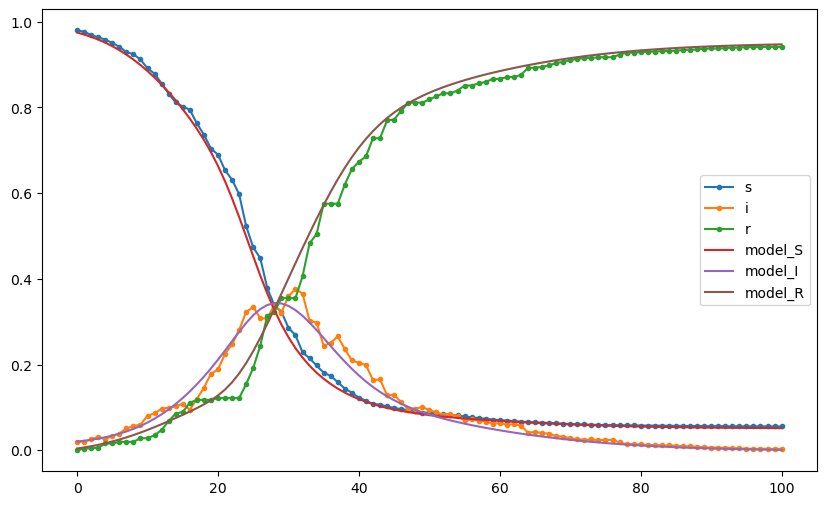

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(t, sir[0, :], 'o-', label = "s", markersize=3)
plt.plot(t, sir[1, :], 'o-', label = "i", markersize=3)
plt.plot(t, sir[2, :], 'o-', label = "r", markersize=3)

plt.plot(t, S, label="model_S")
plt.plot(t, I, label="model_I")
plt.plot(t, R, label="model_R")

plt.legend()

# Conculsion